In [ ]:
!wget http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip

In [ ]:
!unzip spaceappschallenge_seismicdetection_data.zip

In [ ]:
%cd /content
!ls

In [ ]:
Install prerequisite packages for colab
%pip install obspy
%pip install deepod
%pip install noisereduce
%pip install --upgrade torch
%pip install audiomentations
%pip install torch --upgrade
#For Curt - %pip install torch torchinfo torchvision

In [2]:
#Import modules
import numpy as np
import pandas as pd
import scipy
from scipy.signal import hilbert,find_peaks
from scipy.interpolate import UnivariateSpline
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import typing
from typing import *
import gc
from threading import current_thread
from pickle import GLOBAL
import torch
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
%matplotlib inline

In [3]:
#GLOBAL VARIABLES
DATASET_ROOT_PATH="data"

In [4]:
#Dataset
'''
class to assimilate data ,
Input: paths to dataset
Output: Multi-dim matrix,  np.ndarray or torch.tensor
'''
class SeismicDataset:

  def __init__(self,dataset_root:str)->None:
    self.dataset_root=dataset_root
    self.list_of_planets=["lunar","mars"]
    self.modes=["train","test"]
    self.dataset=None
  #Deprecated because it causes RAM consumption, use dataloader instead
  def loadDataset(self,pad_seq=False,ohe=False,n_classes:Optional[int]=1)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      labels=[]
      sampling_rate=[]

      for i,row in self.dataset.iterrows():
        filename=row["filename"]
        time_rel=row["time_rel(sec)"]
        signal = obspy.read(filename + ".mseed")
        fs=signal[0].stats.sampling_rate

        signal_stack.append(signal[0].data)
        labels.append(time_rel)
        sampling_rate.append(fs)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      if ohe:
        labels=self.one_hot_encode(labels,n_classes)
      return signal_stack, labels, sampling_rate

  def loadTestset(self,pad_seq=False)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      sampling_rate=[]

      for i,row in self.testset.iterrows():
        filename=row["filename"]
        signal = obspy.read(filename + ".mseed")
        signal_stack.append(signal[0].data)
        sampling_rate.append(signal[0].stats.sampling_rate)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      return signal_stack, sampling_rate

  def loadPredictions(self, predicted):
      '''
      dataset of shape (Number of samples)
      '''
      filename = []
      for i,row in self.testset.iterrows():
        filename.append(row["filename"])
      df = pd.DataFrame(filename, columns=['Filename'])
      df['prediction'] = predicted
      # TODO convert predicted time slot to an Absolute (or relative?) time

      return df

  def one_hot_encode(self,array:np.ndarray, num_classes:int):
    # Create a zero array of shape (array_len, num_classes)
    n_samples=len(array)
    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())

    one_hot = np.zeros((n_samples,maxlen))

    # Use NumPy's advanced indexing to place 1s
    one_hot[:,np.array(array,dtype=np.uint32)] = 1
    return one_hot

  def padSequences(self,train_data):

    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())
    x_train=np.zeros((len(train_data),maxlen))
    for i,xsample in enumerate(train_data):
      clen=len(xsample)
      x_train[i,:clen]=xsample[:clen]
    return x_train

  def generatePathToLogs(self,mode:Literal["train","test"],planet:Literal["lunar","mars"],split:float=0.8)->None:
    '''
    returns a DataFrame with columns: filename,logname,time_rel(label)
    split: percent of actual train data from train data, rest goes to validation
    '''
    # Extract Catalog for time_rel aka label data
    mode_orig=mode
    mode = "train" if mode in ["train","valid"] else "test"
    if mode in ["train","valid"]:
      mode="train"
      rel_path_to_cat=planet+"/catalog"
      database_roots={"catalog":
                      {
                      planet:
                      {mode:rel_path_to_cat,}
                      }
                    }

      list_of_csvs_path=[]
      for planet_data in database_roots.values():
        for planet,data_cap in planet_data.items():
          for data_category,path in data_cap.items():
            path1=os.path.join(self.dataset_root,path)
            list_dirs=os.listdir(path1)
            for csvpath in list_dirs:
                path2=os.path.join(path1,csvpath)
                assert os.path.isfile(path2), "Path not found"
                list_of_csvs_path.append(path2)

      catalog=[]

      for csv_path in list_of_csvs_path:
        df=pd.read_csv(csv_path)
        df["logname"]=df["filename"].apply(lambda name: name.strip(".csv").strip(".mseed"))

        df.name="_".join(csv_path.split("/")[1:3])
        catalog.append(df)

      del list_of_csvs_path

      catalog=catalog[0]

      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)
                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")
                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}
                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      del list_of_csvs
      training_data=pd.merge(signals_table,catalog, on='logname')
      training_data=training_data.drop(columns=["filename_y"])
      training_data=training_data.rename(columns={"filename_x":"filename"})
      self.dataset=training_data.copy()
      if mode_orig=="valid":
        n_rows_to_drop = int(self.dataset.shape[0] * split)
        # Drop the first split percent of rows
        self.dataset = self.dataset.iloc[n_rows_to_drop:].reset_index(drop=True)

    elif mode=="test":
      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)
                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")
                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}
                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      self.dataset=signals_table.copy()
      del list_of_csvs
      del signals_table

    gc.collect()

'''
Test block
'''
dataTester=SeismicDataset(DATASET_ROOT_PATH)
dataTester.generatePathToLogs(mode="train",planet="lunar")

train_data,train_labels,sampling_rate=dataTester.loadDataset()

In [5]:

#Dataset
'''
PyTorch DataLoader
'''
def custom_collate(batch):
    snippets, labels, labels_b = zip(*batch)
    snippets_padded = pad_sequence(snippets, batch_first=True)
    snippets_padded = torch.squeeze(snippets_padded)
    #labels = torch.tensor(np.array(labels))
    labels = torch.squeeze(torch.tensor(np.vstack(labels)))
    #labels_b = torch.tensor(np.asarray(labels_b))
    #labels_b = torch.tensor(np.array(labels_b))
    labels_b = torch.squeeze(torch.tensor(labels_b))
    return snippets_padded, labels, labels_b

MAX_SEQ_LEN=max(float('-inf'),572400)

class SeismicDataloader(torch.utils.data.Dataset):
    def __init__(self,window_size:int,*args, **kwargs):
        super().__init__()

        global MAX_SEQ_LEN

        dataTester=SeismicDataset(DATASET_ROOT_PATH)
        dataTester.generatePathToLogs(**kwargs)

        mode = kwargs.get("mode")
        self.dataset_map=dataTester.dataset.copy()


        """for i,row in self.dataset_map.iterrows():
          filename=row["filename"]
          if mode != "test":
            time_rel=row["time_rel(sec)"]
          signal = np.array(obspy.read(filename + ".mseed"))
          if MAX_SEQ_LEN < max(signal.shape):
            MAX_SEQ_LEN = max(signal.shape)
          del signal
        MAX_SEQ_LEN=int(MAX_SEQ_LEN/100)*100
        print(MAX_SEQ_LEN)"""

        n_samples=self.dataset_map.shape[0]
        self.length=n_samples*MAX_SEQ_LEN//window_size
        #print(self.length)
        # Initialize other attributes or data loading processes here
        self.current_signal=None
        self.idx_tracker=0
        self.max_seq_len=MAX_SEQ_LEN
        self.window_size=window_size
        self.transform=transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])  # Adjust mean and std based on your data
])
    def __len__(self):
        # Implement length method
        return self.length

    def __getitem__(self, index):

        offset=index*self.window_size
        self.idx_tracker=offset//self.max_seq_len

        if 'time_rel(sec)' not in self.dataset_map:
            self.dataset_map['time_rel(sec)'] = 0
        filename, label = self.dataset_map.iloc[self.idx_tracker][["filename", "time_rel(sec)"]]
        signal = obspy.read(filename + ".mseed")[0].data

        self.current_signal = np.array(signal).reshape(1,-1)

        start = offset-self.idx_tracker * self.max_seq_len
        end = start + self.window_size

        snippet = self.current_signal[:,start:end]

        if snippet.shape[1] < self.window_size:
          padding_width = self.window_size - snippet.shape[1]
          snippet = np.pad(snippet, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)


        if end > self.current_signal.shape[0]:
            self.current_signal = None

        label_ohe = np.zeros((self.window_size), dtype=np.float32)
        label_b=np.array([0])
        if label > start and label < end:
            label_ohe[int(label - start)] = 1.0
            label_b[0]=1
        #snippet = np.expand_dims(snippet, axis=0)
        snippet = torch.tensor(snippet, dtype=torch.float32)
        label_ohe = torch.tensor(label_ohe,dtype=torch.float32)
        label_b = torch.tensor(label_b,dtype=torch.long)

        return snippet, label_ohe, label_b

In [6]:
from torch.utils.data import DataLoader
mydataloader=SeismicDataloader(window_size=30000,mode="train",planet="lunar")

# Create DataLoader with batch size
data_loader = DataLoader(mydataloader, batch_size=32, shuffle=True,collate_fn=custom_collate)
# Iterate through the data loader to get batches
for i, (snippets, label_ohe,label_b) in enumerate(data_loader):
  pos_class=torch.sum(label_b)
  if pos_class:
    print(i, 'Signal detected')
    #print(label_ohe[0])


0 Signal detected
1 Signal detected
2 Signal detected
3 Signal detected
4 Signal detected
5 Signal detected
6 Signal detected
7 Signal detected
8 Signal detected
10 Signal detected
11 Signal detected
12 Signal detected
13 Signal detected
14 Signal detected
15 Signal detected
17 Signal detected
18 Signal detected
19 Signal detected
20 Signal detected
21 Signal detected
22 Signal detected
25 Signal detected
30 Signal detected
32 Signal detected
33 Signal detected
35 Signal detected
37 Signal detected
38 Signal detected
39 Signal detected
40 Signal detected
41 Signal detected
42 Signal detected
43 Signal detected
44 Signal detected


In [7]:
#PreProcessing
'''
Input:Signal
Output: Transformed / Augmented data
'''
class ProcessSignal:
  def __init__(self)->None:
    pass

  def prefilter(self,x:np.ndarray,fs:float, cutoff:float)->None:

    # Take absolute value
    x_abs = np.abs(x)

    # Design low-pass filter
    normal_cutoff = cutoff / (0.5*fs)
    b, a = scipy.signal.butter(2, normal_cutoff, btype='low', analog=False)

    # Apply filter
    envelope = scipy.signal.filtfilt(b, a, x_abs)

    #
    return envelope

  def detectEnvelope(self,x:np.ndarray,N:int,method = 'analytic', window="hamming",prefilter_req=False):
    if prefilter_req:
      x=self.prefilter(x,fs,1)
    x=np.abs(x)
    #Assert that x is a 1D numpy array
    kernel_mapper={"rect":np.ones(N)/N,"hamming":np.hamming(N),"hanning":np.hanning(N),"blackman":np.blackman(N),
                  "gaussian":scipy.signal.windows.gaussian(N,1),"tukey":scipy.signal.windows.tukey(N,1)}
    if method == 'analytic':

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean

      #Take the absolute value of the Hilbert transform
      #to calculate the analytical envelope of the zero mean
      #version of x
      zero_mean_envelope = np.abs(hilbert(x_zero_mean,N = N))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'rms':

      #Assert that N is specified and is an integer
      #For the rms method N serves as window size
      #for the moving average
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean
      #Moving average is calculated using np.convolve


      #Calculate the RMS envelope of the zero mean version of x.
      kernel=kernel_mapper[window]
      #Moving average is calculated using np.convolve
      zero_mean_envelope = np.sqrt(np.convolve(x_zero_mean**2,kernel,mode = 'same'))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'peak':

      #Assert that N is specified and is an integer
      #For the peak method N serves as the minimum number of
      #samples that seperate local maxima
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate local maxima and minima which will serve
      #as peaks for upper and lower envelopes respectively
      peaks_upper,_ = find_peaks(x,distance = N)
      peaks_lower,_ = find_peaks(-x,distance = N)

      #Calculate upper and lower envelopes by interpolating
      #peaks using a Univariate spline
      upper_spline = UnivariateSpline(peaks_upper,x[peaks_upper])
      lower_spline = UnivariateSpline(peaks_lower,x[peaks_lower])
      upper_envelope = upper_spline(np.arange(x.shape[0]))
      lower_envelope = lower_spline(np.arange(x.shape[0]))

      #Return the envelopes
      return upper_envelope,lower_envelope

    else:

      raise ValueError('%s is not a valid method' %(method))

  def compareSignals(self,original:np.ndarray,signal:np.ndarray,fs:float,arrival_time:float,block:Optional[bool]=True)->None:

    plt.close()
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.subplot(2,1,2)
    plt.plot(signal)
    plt.axvline(x=(arrival_time*fs),color="red")
    plt.show()
  '''
  Test block
  '''
#36
#51
#16
#21
#24
#39
#46

idx=10
x_input,x_label,fs=train_data[idx],train_labels[idx],sampling_rate[idx]
p=ProcessSignal()
envelope=p.detectEnvelope(x_input,int(fs*512),'rms',"hamming",True)
envelope=np.array(envelope[0])
#ni,ne=resample_array(x_input[:100000]),resample_array(envelope[:100000])
#p.compareSignals(ni,ne,fs,x_label)


In [8]:
# SeismicModel and dependencies

import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from SeismicModel import SeismicModel

In [9]:
# Model Definition
'''
Define model architectures
Input: tensor signal
Output: binary signal
'''
batch_size = 64
xshape = (batch_size, 30000)
yshape = (batch_size, 30000)

seismic_model = SeismicModel(name="vae-mlp")
seismic_model.SetCollate(custom_collate)
seismic_model.SetDataLoader(mydataloader, xshape, yshape)
seismic_model.BuildModel()

In [10]:
# Model Training
'''
Compile the model (Define optimizers, hyperparams, etc.)
Start/end Training
Store model checkpoints
Plot training and validation loss
'''

seismic_model.Compile(lr=1e-2, batch_size=batch_size)


In [11]:
loss, acc = seismic_model.Train(epochs=5)

Epoch: 1, Batch: 0, Loss: 0.695597767829895
Epoch: 1, Batch: 10, Loss: 0.5766274333000183
Epoch: 1, Batch: 20, Loss: 0.27186262607574463
Epoch: 2, Batch: 0, Loss: 0.16033749282360077
Epoch: 2, Batch: 10, Loss: 0.005506106652319431
Epoch: 2, Batch: 20, Loss: 0.0001689969067228958
Epoch: 3, Batch: 0, Loss: 8.572693332098424e-05
Epoch: 3, Batch: 10, Loss: 2.37680123973405e-05
Epoch: 3, Batch: 20, Loss: 1.7487924196757376e-05
Epoch: 4, Batch: 0, Loss: 2.849345219146926e-05
Epoch: 4, Batch: 10, Loss: 1.3199013665143866e-05
Epoch: 4, Batch: 20, Loss: 1.4803000340180006e-05
Epoch: 5, Batch: 0, Loss: 1.010079586194479e-06
Epoch: 5, Batch: 10, Loss: 1.8567607185104862e-05
Epoch: 5, Batch: 20, Loss: 1.273720681638224e-05


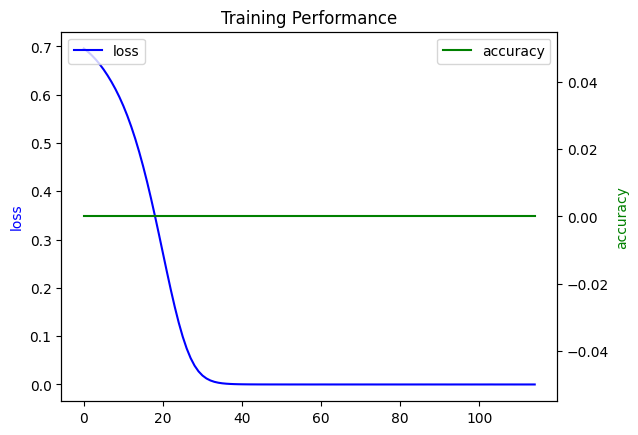

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(seismic_model.history['loss'], color='b')
ax2.plot(seismic_model.history['accuracy'], color='g')
plt.title('Training Performance')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='g')
plt.xlabel('step')
#plt.legend(['train', 'val'], loc='upper left')
ax1.legend(['loss'], loc='upper left')
ax2.legend(['accuracy'], loc='upper right')
plt.show()

In [13]:
testloader=seismic_model.dataloader
data_loader = DataLoader(testloader, batch_size=32, shuffle=False, collate_fn=custom_collate)
snippets,label_ohe,label_b = next(iter(data_loader))
x = snippets
y = label_ohe
y_hat = seismic_model.PredictOne(x[0])
y_loss = y[0] - y_hat
print(np.argmax(y_hat))
print(np.argmax(y[0]))
#print(torch.sum(y_loss))
print(y[0][25430:25450])

tensor(10860)
tensor(25440)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [14]:
#Evaluation on validation set
testloader=SeismicDataloader(window_size=30000,mode="test",planet="lunar")
seismic_model.SetDataLoader(testloader, xshape, yshape)
y_hat = seismic_model.Predict()

In [15]:
print(y_hat[20])

[2.8137097e-06 5.9337392e-08 7.4811732e-07 ... 2.2493039e-06 8.0915152e-07
 8.4827866e-07]


In [16]:
#Prediction
'''
Input: Model, test data
Output: pd.Dataframe or similar table with evaluation results
'''
# use argmax to find the timestamp with the value closest to 1
y_pred = np.argmax(y_hat, axis=1)
print(len(y_pred))
# construct a dataframe
#df = dataTester.loadPredictions(y_pred)
# save as a csv file
#df.to_csv('seismic-detections-'+seismic_model.name+'.csv')

1831


In [ ]:
#Demo app
'''
Input: Model, sample input signal
'''